In [51]:
#import sys
#sys.path.append('../Frontend/match_url')
#print(sys.path)


In [ ]:
from match_url import twitter, epa, bom, health
import numpy as np
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
from maps_ import add_legend, avg_avg_values, create_choropleth
import pandas as pd
import geopandas as gpd
from folium.plugins import HeatMap
from branca.element import Template, MacroElement

## MAP of Cities VS Average Sentiments


[0.07267243419960082, -0.012052884708997805, 0.04934640522875816, 0.3333333333333333, 0.025714285714285696, 0.03555154413101847, 0.038581150975038926, 0.10572463768115943, 0.33149509803921573, -0.009523809523809535, 0.1636904761904762, 0.021060275962236738, 0.11677117443125684, 0.1955128205128205, -0.017543859649122806, 0.08345880574452003, 0.07196969696969698, 0.6619658832800259, 0.21666666666666667, -0.009324128728492836, 0.42444444444444446, -0.1111111111111111, 0.22083333333333333, 0.5333333333333333, 0.08, 0.18181818181818182, -0.02217741935483871, 0.14285714285714285, -0.22480620155038758, 0.0, -0.35714285714285715, 0.125, 0.18245722531436817, 0.29238180120533064, -0.3684210526315789, 0.05762548262548263, 0.027777777777777776, -0.050144300144300144, 0.07004830917874395, 0.16032608695652173, 0.031130268199233715, 0.5, 0.0, -0.6666666666666666, 0.0, -0.021739130434782608, -0.178030303030303, 0.11538461538461539, -0.047619047619047616, 0.0, 0.041666666666666664, 0.0, 0.2092198581560

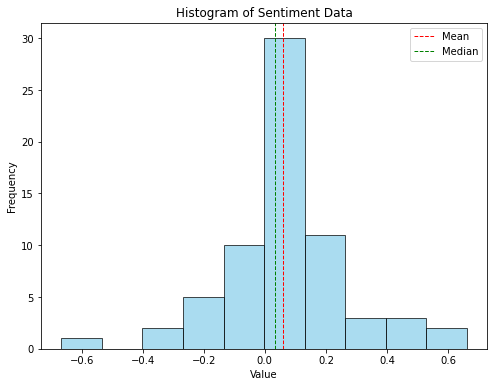

In [86]:
data = twitter()
city_to_senti_count = {}

for i in range(len(data)):
    city = data[i]['full_name']
    sentiments = data[i]['sentiment']
    if city in city_to_senti_count:
        city_to_senti_count[city]["total_sentiment"] += sentiments
        city_to_senti_count[city]["count"] += 1
    else:
        city_to_senti_count[city] = {"total_sentiment": sentiments, "count": 1}
    
city_to_avg_sentiment = {}
for name, values in city_to_senti_count.items():
    avg_sentiment = values["total_sentiment"] / values["count"]
    city_to_avg_sentiment[name] = avg_sentiment

senti_ments = list(city_to_avg_sentiment.values())

# Calculate summary statistics
mean_value = np.mean(senti_ments)
median_value = np.median(senti_ments)

# Visualize data
plt.figure(figsize=(8, 6))

# Create histogram
plt.hist(senti_ments, bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1, label='Median')

# Add legend and labels
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Data')

# Show plot
plt.show()


In [54]:
# Define sentiment levels and corresponding colors
sentiment_levels = {
    "Negative": (min(senti_ments), -0.05),
    "Neutral": (-0.05, 0.1),
    "Positive": (0.1, max(senti_ments))
}

color_map = {
    "Negative": "tomato",
    "Neutral": "burlywood",
    "Positive": "lightseagreen"
}

# Create a map centered around Victoria, Australia
m = folium.Map(location=[-36.8103, 144.2700], zoom_start=6, max_bounds=True, min_zoom=6.8)

# Geocode each city to get its coordinates
geolocator = Nominatim(user_agent="city_sentiments_map")

# Iterate over each city and its average sentiment
for city, sentiment in city_to_avg_sentiment.items():
    try:
        # Get coordinates for the city
        location = geolocator.geocode(city + ", Victoria, Australia")
        if location:
            lat = location.latitude
            lon = location.longitude
            # Determine sentiment level
            for level, (min_val, max_val) in sentiment_levels.items():
                if min_val <= sentiment < max_val:
                    color = color_map[level]
                    break
            else:
                color = "slategray"  # If sentiment does not fall into any level
            
            # Add marker for the city with sentiment color
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{city}: {sentiment}"
            ).add_to(m)
        else:
            print(f"No coordinates found for {city}")
    except Exception as e:
        print(f"Error geocoding {city}: {e}")

# Add legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 215px; height: 120px; 
                 border:2px dark violet; z-index:9999; font-size:12px;
                 background-color: white;
                 ">
      <p style="margin:5px">&nbsp;<strong>Legend of Sentiments</strong></p>
      <p style="margin:5px">&nbsp;<i class="fa fa-circle" style="color:tomato"></i>&nbsp; Negative Sentiment (Below -0.05)</p>
      <p style="margin:5px">&nbsp;<i class="fa fa-circle" style="color:burlywood"></i>&nbsp; Neutral Sentiment (-0.05 to 0.1)</p>
      <p style="margin:5px">&nbsp;<i class="fa fa-circle" style="color:lightseagreen"></i>&nbsp; Positive Sentiment (Above 0.1)</p>
      <p style="margin:5px">&nbsp;<i class="fa fa-circle" style="color:slategrey"></i>&nbsp; Others</p>
      </div>
     '''

add_legend(m, legend_html)

# Set maximum bounds to prevent shrinking
m.fit_bounds(m.get_bounds())

# Save the map to an HTML file
m


No coordinates found for Aireys Inlet - Fairhaven
No coordinates found for Point Lonsdale - Queenscliff


## Disease Distributions in VIC

In [81]:
# import data
health_data = health()
df = pd.DataFrame([health_data[i] for i in range(len(health_data))])
geojson_path = '../data/LGA.geojson'
gdf = gpd.read_file(geojson_path)
merged_gdf = gdf.merge(df, on = 'LGA', how = 'inner')
geoJSON = merged_gdf[['LGA', 'geometry']].drop_duplicates('LGA').to_json()


In [85]:
# show maps with different parameters
create_choropleth(merged_gdf, 'Cancer', geoJSON, genre = 'SR', color = 'YlOrRd')
#create_choropleth(merged_gdf, 'Cancer', geoJSON, genre = 'NUM', color = 'BuPu')
#create_choropleth(merged_gdf, 'Cancer', geoJSON, genre = 'ASR', color = 'YlGn')

c:\Users\cly20\anaconda3\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cly20\anaconda3\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## EPA Maps


In [80]:
# import data
epa_data = epa()
df = pd.DataFrame([epa_data[i] for i in range(len(epa_data))])
# extract data with PM2.5
pm25 = df[df['healthParameter'] == 'PM2.5']
# extract data with particles
particles = df[df['healthParameter'] == 'Particles']


m = folium.Map(location=[-36.8103, 144.2700], zoom_start=6, max_bounds=True, min_zoom=6.8)

# Create a list of tuples containing coordinates and average values
heat_data1 = [[row['coordinates'][0], row['coordinates'][1], row['averageValue']] for index, row in particles.iterrows()]
heat_data2 = [[row['coordinates'][0], row['coordinates'][1], row['averageValue']] for index, row in pm25.iterrows()]

# calculate the average value of each coordinate
data1 = avg_avg_values(heat_data1)
data2 = avg_avg_values(heat_data2)

fg1 = folium.FeatureGroup(name='Heatmap Particle Layer')
fg2 = folium.FeatureGroup(name='Heatmap PM2.5 Layer')

HeatMap(data1).add_to(fg1)
HeatMap(data2).add_to(fg2)

# Add feature groups to map
fg1.add_to(m)
fg2.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Add custom legend outside of the map
legend_html= '''
<div style="position: fixed; 
             bottom: 50px; left: 50px; width: 175px; height: 110px; 
             border:2px solid grey; z-index:9999; font-size:14px;
             background-color: white;
             ">
  <p style="margin:5px">&nbsp;<strong>Legend</strong></p>
  <p style="margin:5px">&nbsp;<span style="color:green">•</span>&nbsp; Low Value</p>
  <p style="margin:5px">&nbsp;<span style="color:orange">•</span>&nbsp; Medium Value</p>
  <p style="margin:5px">&nbsp;<span style="color:red">•</span>&nbsp; High Value</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
# Display the map
m



